# بخش 1

## دانلود و استخراج دیتاست

In [ ]:
!pip install -q wget
import os
import wget
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Markdown

plt.rcParams['font.size'] = 10

In [ ]:
!pip install --upgrade transformers==4.41.0 peft==0.13.1 accelerate==0.33.0 datasets bitsandbytes

  Using cached transformers-4.41.0-py3-none-any.whl.metadata (43 kB)
  Using cached peft-0.13.1-py3-none-any.whl.metadata (13 kB)
  Using cached accelerate-0.33.0-py3-none-any.whl.metadata (18 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached transformers-4.41.0-py3-none-any.whl (9.1 MB)
Using cached peft-0.13.1-py3-none-any.whl (320 kB)
Using cached accelerate-0.33.0-py3-none-any.whl (315 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.1
    Uninstalling numpy-2.3.1:
      Successfully uninstalled numpy-2.3.1
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
  Attemp

In [ ]:
dataset_url = "https://zenodo.org/api/records/10821435/files-archive"
dataset_zip = "roco-dataset.zip"
dataset_dir = "roco-dataset"
images_dir = "roco-dataset/train_images"

##  پیش‌نمایش

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import wget
import zipfile
import pandas as pd

dataset_url = "https://zenodo.org/api/records/10821435/files-archive"
dataset_zip = "roco-dataset.zip"
dataset_dir = "roco-dataset"
images_dir = "roco-dataset/train_images"


if not os.path.exists(dataset_dir):
    print(f" در حال دانلود دیتاست از: {dataset_url}")
    wget.download(dataset_url, dataset_zip)

    backup_path = "/content/drive/MyDrive/roco_backup/roco-dataset.zip"
    os.makedirs(os.path.dirname(backup_path), exist_ok=True)
    os.system(f"cp {dataset_zip} {backup_path}")
    print(f" فایل zip همچنین در مسیر بکاپ ذخیره شد: {backup_path}")


    print(f"\n در حال استخراج دیتاست: {dataset_zip}")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

    os.remove(dataset_zip)

caption_path = "roco-dataset/train_captions.csv"

if os.path.exists(caption_path):
    captions_df = pd.read_csv(caption_path)
    captions_df.columns = ["ID", "Caption"]
    print(f"\n {len(captions_df)} کپشن بارگذاری شد.")
    display(captions_df.sample(5))
else:
    raise FileNotFoundError(" فایل کپشن پیدا نشد.")


 59958 کپشن بارگذاری شد.


,ID,Caption
21819,ROCOv2_2023_train_021894,CT scan of abdomen shows multiple perinephric ...
25004,ROCOv2_2023_train_025094,An extensive keratocystic odontogenic tumor as...
52513,ROCOv2_2023_train_052680,Angiography of the left internal carotid arter...
45859,ROCOv2_2023_train_046004,Parasternal long-axis transthoracic view showi...
48978,ROCOv2_2023_train_049127,MRI at 2 weeks of age showing right hemimegale...


##نمایش چند تصویر

In [ ]:
zip_path = "/content/roco-dataset/train_images.zip"
extract_dir = "/content/roco-dataset/train_images"
image_subfolder = "train"
caption_path = "/content/roco-dataset/train_captions.csv"

In [ ]:
captions_df = pd.read_csv(caption_path)
captions_df.columns = ["ID", "Caption"]
captions_df["filename_jpg"] = captions_df["ID"].apply(lambda x: x + ".jpg")

In [ ]:
full_image_dir = os.path.join(extract_dir, image_subfolder)
all_images = set(os.listdir(full_image_dir))
filtered_df = captions_df[captions_df["filename_jpg"].isin(all_images)]

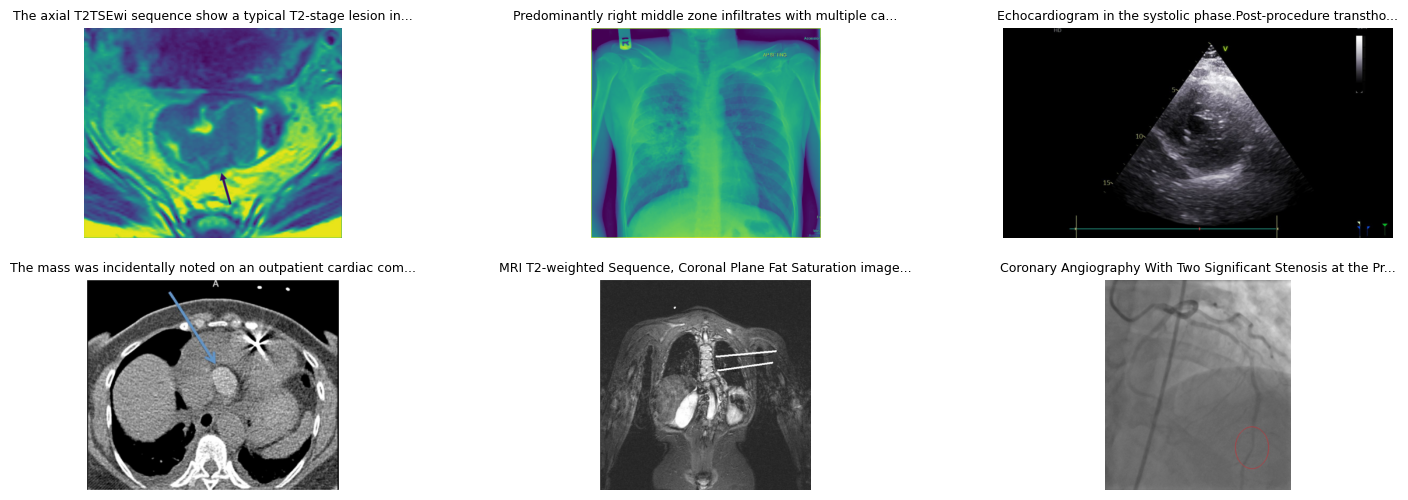

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os


sample_df = filtered_df.sample(6).reset_index(drop=True)

plt.figure(figsize=(18, 6))
for i, row in sample_df.iterrows():
    img_path = os.path.join(full_image_dir, row["filename_jpg"])
    try:
        img = Image.open(img_path)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{row['Caption'][:60]}...", fontsize=9)
    except FileNotFoundError:
        print(f" فایل تصویر یافت نشد: {img_path}")
    except Exception as e:
        print(f" خطای دیگر هنگام باز کردن تصویر {img_path}:\n{type(e).__name__}: {e}")

# بخش3

##blip2-flan-t5-xl مدل

In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import torch
from datasets import Dataset
import pandas as pd
from PIL import Image
import os
import zipfile
from transformers import default_data_collator

In [ ]:
zip_path = "/content/roco-dataset/train_images.zip"
extract_dir = "/content/roco-dataset/train_images"

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("فایل ZIP استخراج شد.")
else:
    print("تصاویر قبلاً استخراج شده‌اند.")


image_folder = os.path.join(extract_dir, "train")
caption_path = "/content/roco-dataset/train_captions.csv"

df = pd.read_csv(caption_path, header=None, names=["filename", "caption"])
df["image_path"] = df["filename"].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))
df = df[df["image_path"].apply(os.path.exists)].reset_index(drop=True)
df = df.sample(6000).reset_index(drop=True)
dataset = Dataset.from_pandas(df[["image_path", "caption"]])

تصاویر قبلاً استخراج شده‌اند.


In [ ]:
!rm -rf ~/.cache/huggingface

In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model
import torch

model_name = "Salesforce/blip2-flan-t5-xl"

processor = Blip2Processor.from_pretrained(model_name, use_fast=False)
model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Add LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "wi", "wo"],
    lora_dropout=0.05,
    bias="none",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


trainable params: 5,505,024 || all params: 3,947,951,616 || trainable%: 0.13944000675412532


In [ ]:
def preprocess(example):
    try:
        image = Image.open(example["image_path"]).convert("RGB")
        prompt = "Describe the medical image in detail."

        inputs = processor(
            images=image,
            text=prompt,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=64
        )

        labels = processor.tokenizer(
            example["caption"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=64
        ).input_ids


        labels[labels == processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": inputs["pixel_values"][0],
            "input_ids": inputs["input_ids"][0],
            "attention_mask": inputs["attention_mask"][0],
            "labels": labels[0]
        }
    except Exception as e:
        print(f"خطا در پردازش: {example['image_path']}")
        return None

In [ ]:
processed = dataset.map(preprocess)
processed = processed.filter(lambda x: x is not None)
processed = processed.remove_columns([col for col in processed.column_names if col not in ["pixel_values", "input_ids", "attention_mask", "labels"]])
subset = processed.select(range(5000))

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
model.save_pretrained("/content/blip2-lora-roco-5k")
processor.save_pretrained("/content/blip2-lora-roco-5k")

In [ ]:
from transformers import Trainer, TrainingArguments, default_data_collator
import os

def train_blip2_on_subset(processed_dataset, num_samples, model, processor, save_path):
    if num_samples > len(processed_dataset):
        raise ValueError("num_samples exceeds dataset size.")

    subset = processed_dataset.select(range(num_samples))

    training_args = TrainingArguments(
        output_dir=save_path,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        num_train_epochs=3,
        learning_rate=5e-5,
        fp16=True,
        logging_steps=20,
        save_strategy="epoch",
        save_total_limit=1,
        remove_unused_columns=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=subset,
        data_collator=default_data_collator
    )

    trainer.train()

    model.save_pretrained(save_path)
    processor.save_pretrained(save_path)

In [ ]:
train_blip2_on_subset(
    processed_dataset=processed,
    num_samples=5000,
    model=model,
    processor=processor,
    save_path="/content/blip2-lora-roco-5k"
)

/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:437: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss
20,0.000000
40,0.000000
60,0.000000
80,0.000000
100,0.000000
120,0.000000
140,0.000000
160,0.000000
180,0.000000
200,0.000000


## BLEU/METEOR/CIDErارزیابی

In [ ]:
!pip install -q evaluate rouge_score nltk

  Preparing metadata (setup.py) ... done


In [ ]:
import evaluate
from tqdm import tqdm
from PIL import Image
import torch
import pandas as pd
from transformers import Blip2Processor, Blip2ForConditionalGeneration

### بارگذاری مدل ذخیره‌شده

In [ ]:
model = Blip2ForConditionalGeneration.from_pretrained("/content/blip2-lora-roco-5k", torch_dtype=torch.float16, device_map="auto")
processor = Blip2Processor.from_pretrained("/content/blip2-lora-roco-5k")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

###  dfساختن مجدد

In [ ]:
df = pd.read_csv("/content/roco-dataset/train_captions.csv", header=None, names=["filename", "caption"])
df["image_path"] = df["filename"].apply(lambda x: f"/content/roco-dataset/train_images/train/{x}.jpg")
df = df[df["image_path"].apply(os.path.exists)].reset_index(drop=True)

### آماده‌سازی نمونه تست از دیتافریم

In [ ]:
test_df = df.sample(200).reset_index(drop=True)
predictions = []
references = []

model.eval()
for i in tqdm(range(len(test_df))):
    img_path = test_df.loc[i, "image_path"]
    ref_caption = test_df.loc[i, "caption"]
    try:
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=30)
        generated_caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        predictions.append(generated_caption)
        references.append(ref_caption)
    except:
        continue

100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


### محاسبه متریک‌ها

In [ ]:
bleu = evaluate.load("bleu")
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])

rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references)

meteor = evaluate.load("meteor")
meteor_result = meteor.compute(predictions=predictions, references=references)

try:
    cider = evaluate.load("cider")
    cider_result = cider.compute(predictions=predictions, references=[[ref] for ref in references])
except:
    cider_result = {"CIDEr": "not available"}

print("\n نتایج ارزیابی مدل BLIP-2:")
print(f"BLEU: {bleu_result['bleu']:.4f}")
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"CIDEr: {cider_result.get('CIDEr', 'N/A')}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



 نتایج ارزیابی مدل BLIP-2:
BLEU: 0.0036
ROUGE-L: 0.1448
METEOR: 0.0765
CIDEr: not available
